# Challenge: Walk Forward on Other Datasets

## Download data from `yfinance`

In [2]:
import yfinance as yf

ticker = 'PHG'
df = yf.download(ticker)
df = df.droplevel('Ticker', axis=1)


[*********************100%***********************]  1 of 1 completed


## Preprocess the data

### Filter the date range

In [3]:
df = df.loc['2020-01-01':].copy()

### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [4]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100

#### Remove rows with any missing data

<Axes: xlabel='Date'>

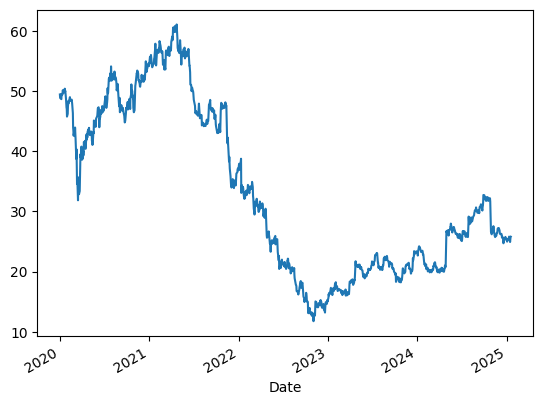

In [5]:
df = df.dropna().copy()
df.Close.plot()

## Machine Learning modelling

### Separate the data

1. Target: which variable do you want to predict?
2. Explanatory: which variables will you use to calculate the prediction?

In [6]:
y = df.change_tomorrow
X = df[['Adj Close','Open','High','Low','Close','Volume']]
y = df.change_tomorrow

### Time Series Split

In [202]:
from sklearn.model_selection import TimeSeriesSplit

In [203]:
ts = TimeSeriesSplit(test_size=200)

### Compute and evaluate model in a for loop

1. Separate the data in train and test
2. Compute the model on the train set
3. Evaluate the model (mse) on the test set
4. Append the errors (mse) in an empty list

In [204]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [205]:
list_mse = []

for index_train, index_test in ts.split(y):
  model = RandomForestRegressor(max_depth=25, random_state=42)
  X_train, y_train = X.iloc[index_train], y.iloc[index_train]
  X_test, y_test = X.iloc[index_test], y.iloc[index_test]
  model.fit(X_train, y_train)
  y_pred_text = model.predict(X=X_test)
  mse = mean_squared_error(y_test, y_pred_text)

  list_mse.append(mse)

In [206]:
print(list_mse)

[2.4627251700275927, 15.817135985127848, 12.17806188883958, 3.600791902533936, 7.317035694861882]


## Anchored Walk Forward evaluation in backtesting

![](<src/10_Table_Validation Methods.png>)

### Create a new strategy

In [207]:
from backtesting import Strategy

In [208]:
def d(date):
  return date.strftime("%Y-%m-%d")

In [245]:
class Regression(Strategy):
    limit_buy = 2
    limit_sell = -4
    already_bought = False
    n_train = 600
    coef_retrain = 12
    show_training_periods = False
    show_prediction_date = False 
    max_depth=20

    def init(self):
        self.model = RandomForestRegressor(max_depth=self.max_depth, random_state=42)

        # WHY bother training, never used!            
        X_train = self.data.df.iloc[:-1,:-1]
        y_train = self.data.df.iloc[:-1, -1]
        
        self.model.fit(X=X_train, y=y_train)
        print("init regression training")

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :-1]
        if self.show_prediction_date:
            print(f"\tpredict {d(explanatory_today.index)}")
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [236]:
class WalkForwardAnchored(Regression):
  
    def next(self):
      L = len(self.data)
    
      if L<self.n_train:
         return
      
      if L % self.coef_retrain == 0:
         X_train = self.data.df.iloc[:-1,:-1]
         y_train = self.data.df.iloc[:-1, -1]
         self.model.fit(X=X_train, y=y_train)
         if self.show_training_periods:
            print(f"At {L}: period from {d(X_train.index[0])} to {d(X_train.index[-1])}, buy at {self.limit_buy}, sell at {self.limit_sell}, depth {self.max_depth}, size {self.coef_retrain}")
      
      super().next()

### Run the backtest with optimization

In [237]:
import multiprocessing as mp
try:
  mp.set_start_method('fork')
except:
  print("already set")

already set


In [238]:
from backtesting import Backtest
bt = Backtest(df, WalkForwardAnchored, cash=10000, commission=.002, exclusive_orders=True)

In [239]:
bt.run()

init regression training


Start                     2020-01-02 00:00...
End                       2024-11-26 00:00...
Duration                   1790 days 00:00:00
Exposure Time [%]                   47.692308
Equity Final [$]                          0.0
Equity Peak [$]                  10184.452919
Return [%]                             -100.0
Buy & Hold Return [%]              -45.592397
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              159.446492
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                      -100.0
Max. Drawdown Duration     1050 days 00:00:00
Avg. Drawdown Duration     1050 days 00:00:00
# Trades                                    6
Win Rate [%]                        33.333333
Best Trade [%]                      11.295402
Worst Trade [%]                   -101.501916
Avg. Trade [%]                    

In [214]:
import pandas as pd 
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)


In [215]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy = [0,1,2,3], limit_sell = [-5,-4,-3,-2,-1,0], 
    # max_depth = [21,22],
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

At 500: period from 2020-01-02 to 2021-12-22, buy at 1, sell at -2, depth 20, size 10
At 510: period from 2020-01-02 to 2022-01-06, buy at 1, sell at -2, depth 20, size 10
At 520: period from 2020-01-02 to 2022-01-21, buy at 1, sell at -2, depth 20, size 10
At 530: period from 2020-01-02 to 2022-02-04, buy at 1, sell at -2, depth 20, size 10
At 540: period from 2020-01-02 to 2022-02-18, buy at 1, sell at -2, depth 20, size 10
At 550: period from 2020-01-02 to 2022-03-07, buy at 1, sell at -2, depth 20, size 10
At 560: period from 2020-01-02 to 2022-03-21, buy at 1, sell at -2, depth 20, size 10
At 570: period from 2020-01-02 to 2022-04-04, buy at 1, sell at -2, depth 20, size 10
At 580: period from 2020-01-02 to 2022-04-19, buy at 1, sell at -2, depth 20, size 10
At 590: period from 2020-01-02 to 2022-05-03, buy at 1, sell at -2, depth 20, size 10
At 600: period from 2020-01-02 to 2022-05-17, buy at 1, sell at -2, depth 20, size 10
At 610: period from 2020-01-02 to 2022-06-01, buy at 1

/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 0] before, using random point [3, -4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 0] before, using random point [2, -3]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 0] before, using random point [3, -2]
  warnings.warn(


At 500: period from 2020-01-02 to 2021-12-22, buy at 3, sell at -2, depth 20, size 10
At 510: period from 2020-01-02 to 2022-01-06, buy at 3, sell at -2, depth 20, size 10
At 520: period from 2020-01-02 to 2022-01-21, buy at 3, sell at -2, depth 20, size 10
At 530: period from 2020-01-02 to 2022-02-04, buy at 3, sell at -2, depth 20, size 10
At 540: period from 2020-01-02 to 2022-02-18, buy at 3, sell at -2, depth 20, size 10
At 550: period from 2020-01-02 to 2022-03-07, buy at 3, sell at -2, depth 20, size 10
At 560: period from 2020-01-02 to 2022-03-21, buy at 3, sell at -2, depth 20, size 10
At 570: period from 2020-01-02 to 2022-04-04, buy at 3, sell at -2, depth 20, size 10
At 580: period from 2020-01-02 to 2022-04-19, buy at 3, sell at -2, depth 20, size 10
At 590: period from 2020-01-02 to 2022-05-03, buy at 3, sell at -2, depth 20, size 10
At 600: period from 2020-01-02 to 2022-05-17, buy at 3, sell at -2, depth 20, size 10
At 610: period from 2020-01-02 to 2022-06-01, buy at 3

/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 0] before, using random point [0, -1]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 0] before, using random point [0, -1]
  warnings.warn(


At 500: period from 2020-01-02 to 2021-12-22, buy at 3, sell at 0, depth 20, size 10
At 510: period from 2020-01-02 to 2022-01-06, buy at 3, sell at 0, depth 20, size 10
At 520: period from 2020-01-02 to 2022-01-21, buy at 3, sell at 0, depth 20, size 10
At 530: period from 2020-01-02 to 2022-02-04, buy at 3, sell at 0, depth 20, size 10
At 540: period from 2020-01-02 to 2022-02-18, buy at 3, sell at 0, depth 20, size 10
At 550: period from 2020-01-02 to 2022-03-07, buy at 3, sell at 0, depth 20, size 10
At 560: period from 2020-01-02 to 2022-03-21, buy at 3, sell at 0, depth 20, size 10
At 570: period from 2020-01-02 to 2022-04-04, buy at 3, sell at 0, depth 20, size 10
At 580: period from 2020-01-02 to 2022-04-19, buy at 3, sell at 0, depth 20, size 10
At 590: period from 2020-01-02 to 2022-05-03, buy at 3, sell at 0, depth 20, size 10
At 600: period from 2020-01-02 to 2022-05-17, buy at 3, sell at 0, depth 20, size 10
At 610: period from 2020-01-02 to 2022-06-01, buy at 3, sell at 0

,limit_buy,limit_sell,Return [%]
16,3,0,56.511525
15,3,-2,-6.886159
14,3,-3,-6.886159
13,3,-4,-6.886159
7,1,-2,-8.723345
11,2,-2,-13.115749
2,0,-2,-25.191289
9,2,-4,-32.409048
6,1,-3,-33.362086
12,2,-1,-39.407719


In [216]:
bt.plot(filename="./reports_backtesting/10C-anchored.html")

Row(id='4467', ...)

## Unanchored Walk Forward

### Create a library of strategies

### Create the unanchored walk forward class

In the previously created library

![](<src/10_Table_Validation Methods.png>)

### Import the strategy and perform the backtest with optimization

In [240]:
%load_ext autoreload
%autoreload 2

In [241]:
class WalkForwardUnanchored(Regression):
    def next(self):
        L = len(self.data)

        if L < self.n_train:
            return
        
        # we retrain the model each 200 days
        if L % self.coef_retrain == 0:
            X_train = self.data.df.iloc[-self.n_train:-1, :-1]
            y_train = self.data.df.iloc[-self.n_train:-1, -1]
            if self.show_training_periods:
                print(f"At {L}: period from {d(X_train.index[0])} to {d(X_train.index[-1])}, buy at {self.limit_buy}, sell at {self.limit_sell}, depth {self.max_depth}, size {self.coef_retrain}")

            self.model.fit(X_train, y_train)
            
        super().next()

In [246]:
bt_unanchored = Backtest(df, WalkForwardUnanchored , cash=10000, commission=.002, exclusive_orders=True)
bt_unanchored.run()
# bt_unanchored.optimize(???)

init regression training


Start                     2020-01-02 00:00...
End                       2024-11-26 00:00...
Duration                   1790 days 00:00:00
Exposure Time [%]                   61.700405
Equity Final [$]                  2699.921336
Equity Peak [$]                  10065.726226
Return [%]                         -73.000787
Buy & Hold Return [%]              -45.592397
Return (Ann.) [%]                   -23.44598
Volatility (Ann.) [%]               38.635351
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -90.079515
Avg. Drawdown [%]                  -45.865423
Max. Drawdown Duration     1104 days 00:00:00
Avg. Drawdown Duration      554 days 00:00:00
# Trades                                    4
Win Rate [%]                             25.0
Best Trade [%]                      39.657291
Worst Trade [%]                    -67.502971
Avg. Trade [%]                    

In [247]:
stats_skopt, heatmap, optimize_result = bt_unanchored.optimize(
    limit_buy = [0,1,2,3], limit_sell = [-5,-4,-3,-2,-1,0], 
    # max_depth = [21,22],
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training
init regression training


/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [0, -1]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [1, -4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [2, -4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using ra

init regression training


/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [1, -2]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [0, 0]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [2, -4]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using ran

init regression training


/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [3, -3]
  warnings.warn(
/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, -1] before, using random point [3, -3]
  warnings.warn(


init regression training


,limit_buy,limit_sell,Return [%]
9,1,-1,56.506651
10,1,0,7.269726
7,1,-3,6.330048
8,1,-2,4.990106
4,0,0,-31.368866
17,3,-3,-33.473131
18,3,0,-45.839521
2,0,-2,-49.613462
15,3,-5,-52.483067
12,2,-3,-56.939487


### Interpret the strategies' performance

In [248]:
bt_unanchored.plot(filename="reports_backtesting/10C-unachored.html")

Row(id='7527', ...)

In [ ]:
bt_unanchored.???

## Course Conclusion

Watch video → [Next steps]()